In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
timepoint_map = [0, 9, 19, 29, 39, 49, 99, 199, 299]
hidden = (
    torch.load("/Users/eric/Downloads/latents.pt")
    .transpose(1, 0)
    .flatten(2)
    .contiguous()
)
print(f"Hidden state shape: {hidden.shape}")

true_latents = torch.load("/Users/eric/Downloads/envs.pt")
print(f"True latents shape: {true_latents.shape}")

Hidden state shape:	 torch.Size([9, 12288, 2304])
True latents shape:	 torch.Size([12288, 12])


# Dimensionality

In [ ]:
mat = hidden - hidden.mean(1, keepdim=True)
s = torch.linalg.svdvals(mat)
var = s**2 / (mat.shape[1] - 1)
dim = var.sum(1) ** 2 / (var**2).sum(1)

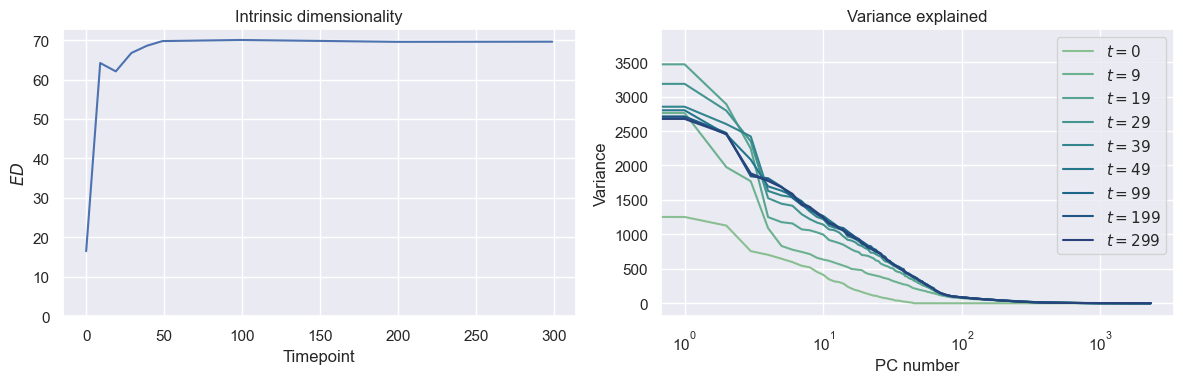

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(timepoint_map, dim)
axs[0].set(
    title="Intrinsic dimensionality", xlabel="Timepoint", ylabel="$ED$", ylim=(0, None)
)

cp = sns.color_palette("crest", n_colors=var.shape[0])
for i in range(var.shape[0]):
    axs[1].plot(var[i], color=cp[i], label=f"$t = {timepoint_map[i]}$")
axs[1].set(
    title="Variance explained", xlabel="PC number", ylabel="Variance", xscale="log"
)
axs[1].legend()

fig.tight_layout()
plt.show()

# Classification of true latents

In [9]:
def accuracies(pred, true):
    correct = pred == true
    all_correct = correct.all(1)
    return correct.mean(), all_correct.mean()


def fit_classifier(X, y, n_folds=5, low_dim=100):
    if isinstance(X, torch.Tensor):
        X = X.numpy()
    if isinstance(y, torch.Tensor):
        y = y.numpy()

    if low_dim is not None:
        X = PCA(n_components=low_dim).fit_transform(X)

    kfold = KFold(n_splits=n_folds)
    metrics = []
    for train_indices, test_indices in tqdm(kfold.split(X), total=n_folds):
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        y_pred_train, y_pred_test = [], []
        for label_index in range(y.shape[1]):
            clf = LogisticRegression(max_iter=1000)
            clf.fit(X_train, y_train[:, label_index])
            y_pred_train_i = clf.predict(X_train)
            y_pred_test_i = clf.predict(X_test)
            y_pred_train.append(y_pred_train_i)
            y_pred_test.append(y_pred_test_i)
        y_pred_train = np.stack(y_pred_train, axis=1)
        y_pred_test = np.stack(y_pred_test, axis=1)

        train_accuracy, train_all_correct = accuracies(y_pred_train, y_train)
        test_accuracy, test_all_correct = accuracies(y_pred_test, y_test)
        metrics += [
            {
                "split": "test",
                "accuracy": test_accuracy,
                "all_correct": test_all_correct,
            },
            {
                "split": "train",
                "accuracy": train_accuracy,
                "all_correct": train_all_correct,
            },
        ]

    metrics = pd.DataFrame(metrics)
    return metrics

In [43]:
metrics = []
for i, t in enumerate(timepoint_map):
    metrics_t = fit_classifier(hidden[i], true_latents)
    metrics_t["timepoint"] = t
    metrics.append(metrics_t)
metrics = pd.concat(metrics)

baseline_metrics = {
    "accuracy": (1 / (true_latents.max(dim=0).values + 1)).mean().item(),
    "all_correct": (1 / (true_latents.max(dim=0).values + 1)).prod().item(),
}

 20%|██        | 1/5 [00:02<00:09,  2.31s/it]/Users/eric/miniconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


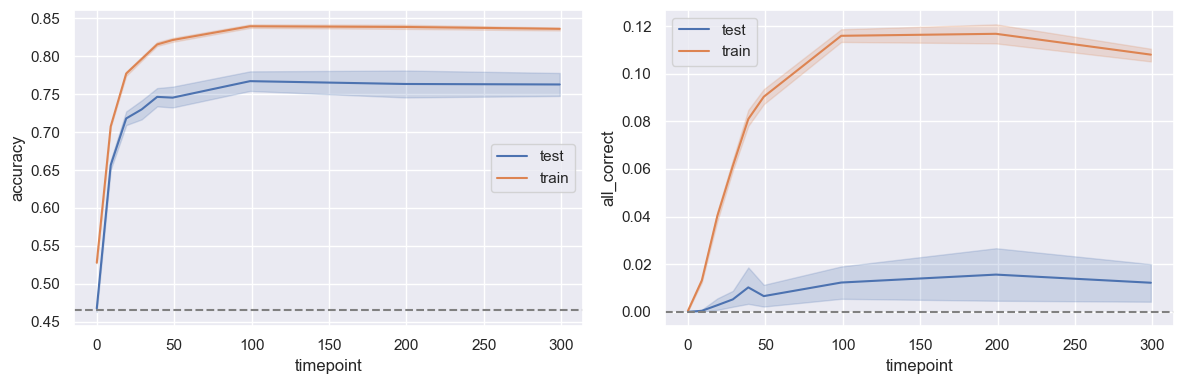

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, metric_name in enumerate(["accuracy", "all_correct"]):
    sns.lineplot(data=metrics, x="timepoint", y=metric_name, hue="split", ax=axs[i])
    axs[i].axhline(baseline_metrics[metric_name], linestyle="--", color="grey")
    axs[i].legend()

fig.tight_layout()
plt.show()

# Topological similarity (i.e., compositionality w.r.t. true latents)

In [18]:
def topological_similarity(w, z, metric="cosine"):
    w = F.one_hot(w).float().numpy().reshape(w.shape[0], -1)
    z_rdm = pdist(z, metric=metric)
    w_rdm = pdist(w, metric="cityblock")
    topsim = pearsonr(z_rdm, w_rdm).statistic
    return topsim


def bootstrap_topological_similarity(
    w,
    z,
    metric="euclidean",
    n_samples=1000,
    n_bootstraps=100,
):
    topsims = []
    for _ in tqdm(range(n_bootstraps)):
        indices = np.random.choice(np.arange(w.shape[0]), size=n_samples, replace=True)
        topsims.append(topological_similarity(w[indices], z[indices], metric=metric))
    return np.array(topsims)


topsims = []
for i, t in enumerate(timepoint_map):
    topsims_t = bootstrap_topological_similarity(
        true_latents.long(), hidden[i], n_samples=1000, n_bootstraps=10
    )
    topsims_t = pd.DataFrame(topsims_t, columns=["topological_similarity"])
    topsims_t["timepoint"] = t
    topsims.append(topsims_t)
topsims = pd.concat(topsims)

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


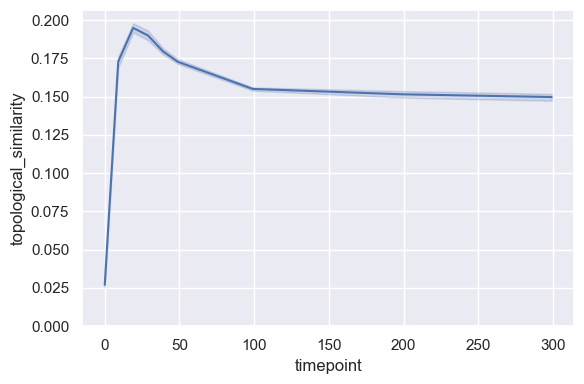

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=topsims, x="timepoint", y="topological_similarity", ax=ax)
ax.set(ylim=(0, None))
fig.tight_layout()
plt.show()

# Attractors

In [4]:
timepoint_map = [0, 9, 19, 29, 39, 49, 99, 199, 299]
hidden = (
    torch.load("/Users/eric/Downloads/latents_attractors.pt")
    .transpose(2, 1)
    .flatten(3)
    .contiguous()
)  # (envs, timepoints, trajectory samples, representation dim)
print(f"Hidden state shape: {hidden.shape}")

hidden_shuffled = (
    (
        torch.load("/Users/eric/Downloads/latents_attractors.pt")
        .flatten(3)
        .view(hidden.shape[0] * hidden.shape[2], hidden.shape[1], hidden.shape[3])
        .contiguous()
    )[torch.randperm(hidden.shape[0] * hidden.shape[2])]
    .view(hidden.shape[0], hidden.shape[2], hidden.shape[1], hidden.shape[3])
    .transpose(2, 1)
    .contiguous()
)
print(f"Hidden state shuffled shape: {hidden.shape}")

true_latents = torch.load("/Users/eric/Downloads/envs_attractors.pt")
print(f"True latents shape: {true_latents.shape}")

Hidden state shape: torch.Size([100, 9, 100, 2304])
Hidden state shuffled shape: torch.Size([100, 9, 100, 2304])
True latents shape: torch.Size([100, 12])


In [5]:
def pairwise_distances(x: torch.Tensor, metric="euclidean"):
    b, r, d = x.shape

    # Compute pairwise differences or cosine similarity
    if metric == "euclidean":
        # Calculate the pairwise squared distance
        x1 = x.unsqueeze(2)  # [B, R, 1, D]
        x2 = x.unsqueeze(1)  # [B, 1, R, D]
        pairwise_diff = (x1 - x2).pow(2).sum(dim=-1)  # [B, R, R]
        pairwise_dist = torch.sqrt(pairwise_diff)  # [B, R, R]
    elif metric == "cosine":
        # Normalize input vectors to unit vectors
        x_norm = F.normalize(x, dim=-1)  # [B, R, D]
        # Compute cosine similarity
        pairwise_similarity = torch.matmul(
            x_norm, x_norm.transpose(-1, -2)
        )  # [B, R, R]
        # Convert to cosine distance
        pairwise_dist = 1 - pairwise_similarity  # [B, R, R]
    else:
        raise ValueError(
            f"Unsupported metric '{metric}'. Choose 'euclidean' or 'cosine'."
        )

    # Extract upper triangular part (excluding the diagonal)
    i, j = torch.triu_indices(r, r, offset=1)
    pairwise_dist = pairwise_dist[:, i, j]  # [B, R(R-1)/2]

    return pairwise_dist


def pairwise_distances_df(x: torch.Tensor, metric="euclidean"):
    e, t, s, d = x.shape
    pdist = pairwise_distances(x.view(e * t, s, d), metric=metric).view(e, t, -1)
    pdist = pd.DataFrame(
        [
            {
                "environment": i,
                "timepoint": timepoint_map[j],
                "distance": pdist[i, j].mean().item(),
            }
            for i in range(e)
            for j in range(t)
        ]
    )
    return pdist

In [6]:
pdists = pairwise_distances_df(hidden[torch.randperm(hidden.shape[0])][:10], metric="euclidean")

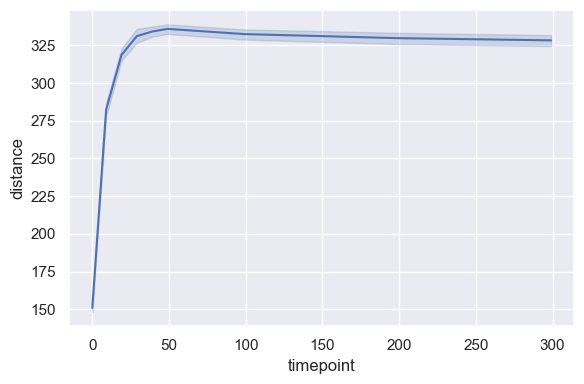

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=pdists, x="timepoint", y="distance", ax=ax)
fig.tight_layout()
plt.show()